In [1]:
from torchsift import sift, utils, ransac
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import torchvision.transforms as T
from PIL import Image
import torch
from tqdm.auto import tqdm
torch.manual_seed(19971222)


In [2]:
resize = T.Resize(256)
transforms = T.Compose([T.Resize(256), T.RandomRotation(30), T.RandomAffine(0, translate=(0.2, 0.2)), T.RandomPerspective(distortion_scale=0.5), T.PILToTensor()])

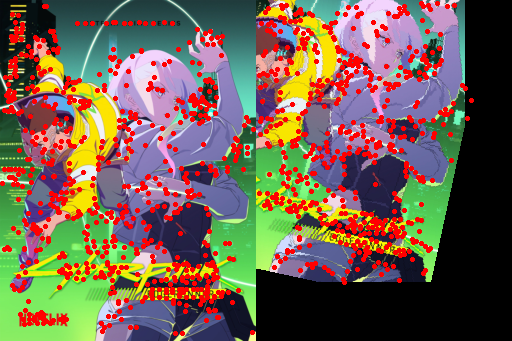

In [3]:
example_image_path = 'example.jpg'
image = Image.open(example_image_path).convert('RGB')

index_image = resize(image)
index_image = pil_to_tensor(index_image)
query_image = transforms(image)

idx_kps, idx_descs = sift.detect(index_image)
index_kps_image = utils.visualize_keypoints(index_image, idx_kps.unsqueeze(0))

query_kps, query_descs = sift.detect(query_image)
query_kps_image = utils.visualize_keypoints(query_image, query_kps.unsqueeze(0))

side_by_side = utils.concat(index_kps_image, query_kps_image, dim=1)
side_by_side

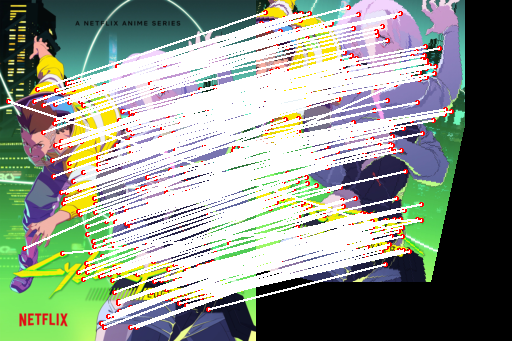

In [4]:
idx_idesc_qdesc = sift.match(idx_descs.unsqueeze(0), query_descs.unsqueeze(0))
idx_ikp, idx_qkp = sift.inflate(idx_kps.unsqueeze(0), query_kps.unsqueeze(0), idx_idesc_qdesc)
lines_without_ransac = utils.draw_match_lines(index_image, query_image, idx_ikp.squeeze(0), idx_qkp.squeeze(0))
lines_without_ransac

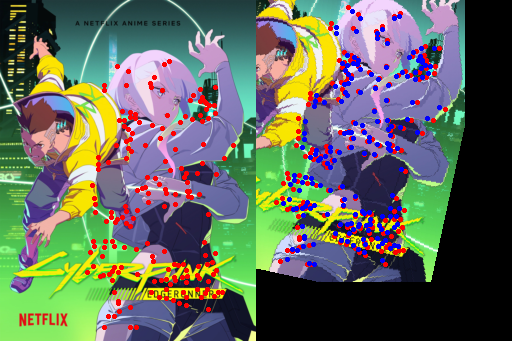

In [5]:
H, selected_X, selected_Y, IX, IY = ransac.select(idx_ikp, idx_qkp)
ransac_index_kps_image = utils.visualize_keypoints(index_image, selected_X.unsqueeze(0))
ransac_query_kps_image = utils.visualize_keypoints(query_image, selected_Y.unsqueeze(0))

ransac_kps_side_by_side = utils.draw_transfrom_points(index_image, query_image, H, selected_X, selected_Y)
ransac_kps_side_by_side

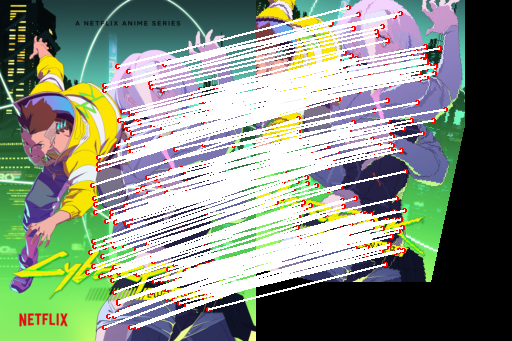

In [6]:
ransac_lines_side_by_size = utils.draw_match_lines(index_image, query_image, selected_X, selected_Y)
ransac_lines_side_by_size

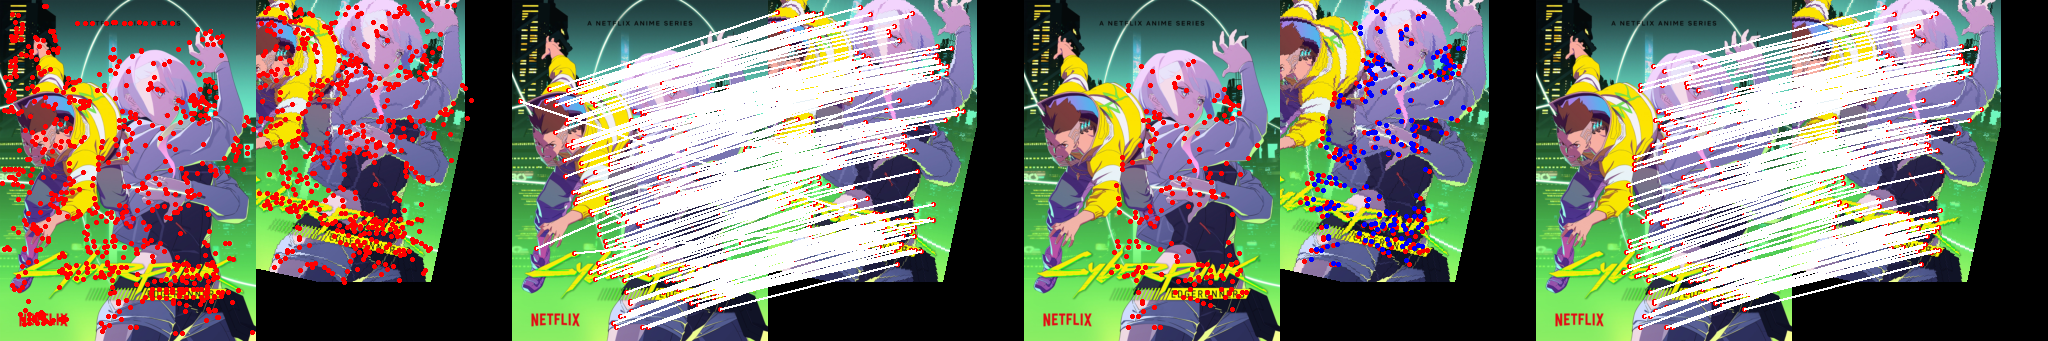

In [7]:
outcome = utils.concat(side_by_side, lines_without_ransac)
outcome = utils.concat(outcome, ransac_kps_side_by_side)
outcome = utils.concat(outcome, ransac_lines_side_by_size)
outcome

In [8]:
import time

In [9]:
N = 10000
index_images = torch.randint(0, 255, (N, 3, 64, 256), dtype=torch.uint8, device='cuda').cpu()
query_images = torch.randint(0, 255, (N, 3, 64, 256), dtype=torch.uint8, device='cuda').cpu()

chunk_size = 512
n_chunks = N // chunk_size

In [10]:
# detect keypoints and descriptors
start_time = time.time()
idx_kps_descs = [sift.detect(i, device='cuda') for i in index_images]
qry_kps_deescs = [sift.detect(q, device='cuda') for q in query_images]
end_time = time.time()
total = end_time - start_time
avg_time = (end_time - start_time) * 1000 / N
print(f'Total time of OpenCV SITF detecting on {N} images: {total}s')
print(f'Average time of OpenCV SITF detecting per image: {avg_time}ms')

Total time of OpenCV SITF detecting on 10000 images: 54.05860161781311s
Average time of OpenCV SITF detecting per image: 5.405860161781311ms


In [11]:
# sample keypoints and descriptors to have the same size
start_time = time.time()
idx_kps, idx_descs = list(zip(*idx_kps_descs))
idx_kps, idx_descs = sift.sample(idx_kps, idx_descs)
qry_kps, qry_descs = list(zip(*qry_kps_deescs))
qry_kps, qry_descs = sift.sample(qry_kps, qry_descs)
end_time = time.time() 
total = end_time - start_time
avg_time =  (end_time - start_time) * 1000 / N
print(f'Total time of TorchSIFT sampling on {N} images: {total}s')
print(f'Average time of TorchSIFT sampling per image: {avg_time}ms')

Total time of TorchSIFT sampling on 10000 images: 5.620657920837402s
Average time of TorchSIFT sampling per image: 0.5620657920837402ms


In [12]:
# match keypoints and descriptors
start_time = time.time()
for i in (pbar := tqdm(range(n_chunks))):
    idx_descs_chunk = idx_descs[i * chunk_size: (i + 1) * chunk_size]
    idx_kps_chunk = idx_kps[i * chunk_size: (i + 1) * chunk_size]
    qry_descs_chunk = qry_descs[i * chunk_size: (i + 1) * chunk_size]
    qry_kps_chunk = qry_kps[i * chunk_size: (i + 1) * chunk_size]
    idx_idesc_qdesc = sift.match(idx_descs_chunk, qry_descs_chunk)
end_time = time.time()
total = end_time - start_time
avg_time =  (end_time - start_time) * 1000 / N
print(f'Total time of TorchSIFT matching on {N} images: {total}s')
print(f'Average time of TorchSIFT matching per image: {avg_time}ms')
    


  0%|          | 0/19 [00:00<?, ?it/s]

Total time of TorchSIFT matching on 10000 images: 1.540123701095581s
Average time of TorchSIFT matching per image: 0.1540123701095581ms


In [13]:
N = 10000
idx_kps = torch.randint(0, 255, (N, 256, 2), device='cuda')
query_kps = torch.randint(0, 255, (N, 256, 2), device='cuda')
idx_idesc_qdesc = torch.randint(0, 255, (N, 256, 256), device='cuda')
chunk_size = 512
n_chunks = N // chunk_size

In [14]:
# ransac    
start_time = time.time()
for i in (pbar := tqdm(range(n_chunks))):
    idx_ikp_chunk = idx_kps[i * chunk_size: (i + 1) * chunk_size]
    idx_qkp_chunk = query_kps[i * chunk_size: (i + 1) * chunk_size]
    idx_ikp_chunk, idx_qkp_chunk = sift.inflate(idx_ikp_chunk, idx_qkp_chunk, idx_idesc_qdesc)
    H, selected_X, selected_Y, IX, IY = ransac.select(idx_ikp_chunk, idx_qkp_chunk)
end_time = time.time()
total = end_time - start_time
avg_time =  (end_time - start_time) * 1000 / N
print(f'Total time of TorchSIFT RANSAC on {N} images: {total}s')
print(f'Average time of TorchSIFT RANSAC per image: {avg_time}ms')

  0%|          | 0/19 [00:00<?, ?it/s]

Total time of TorchSIFT RANSAC on 10000 images: 36.305274963378906s
Average time of TorchSIFT RANSAC per image: 3.6305274963378906ms


In [15]:
#%%capture
#!jupyter nbconvert --execute --to markdown README.ipynb